In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.3 MB/s eta 0:00:00


Generating training data (this can take a minute)...
Training set shapes: (2250, 4) (2250, 3)
[ResNet epoch 000] train_mse=245.788584  val_mse=219.512177
[ResNet epoch 010] train_mse=34.423918  val_mse=33.392895
[ResNet epoch 020] train_mse=19.820138  val_mse=18.668858
[ResNet epoch 030] train_mse=15.242748  val_mse=13.569482
[ResNet epoch 040] train_mse=12.813524  val_mse=11.426657
[ResNet epoch 050] train_mse=11.392990  val_mse=10.231170
[ResNet epoch 059] train_mse=10.519135  val_mse=9.479552
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.090046 s

'compile' took 0.278805 s

Training DeepXDE model (this may take some time depending on iterations)...
Training model...

0         [2.96e+02]    [3.01e+02]    []  
1000      [6.45e+

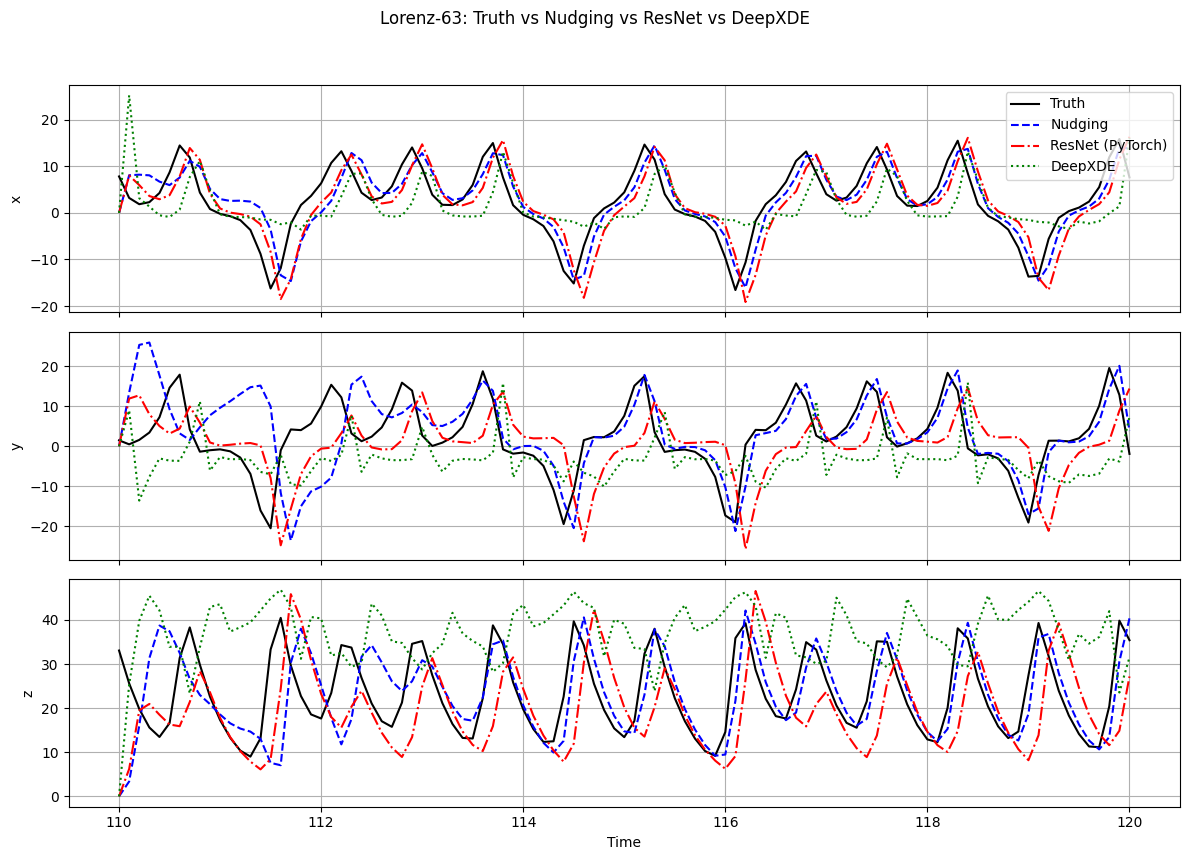

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Lorenz-63 + Nudging + ResNet (PyTorch) + DeepXDE demo + plotting

- Produces training pairs via nudging (same as your template).
- Trains a small PyTorch ResNet (existing code).
- Trains a DeepXDE FNN (supervised) to learn the same one-step map.
- Compares multi-step rollouts: Truth vs Nudging vs ResNet vs DeepXDE.
- Plots x,y,z over observation times for visual comparison.
"""

import deepxde as dde
from deepxde.backend.set_default_backend import set_default_backend
from dataclasses import dataclass
import math
import random
import numpy as np
from typing import Tuple, List
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ------------------------------
# ODEs: Lorenz 63
# ------------------------------

@dataclass
class Lorenz63Params:
    sigma: float = 10.0
    rho: float = 28.0
    beta: float = 8.0 / 3.0

def lorenz63_rhs(u: np.ndarray, p: Lorenz63Params) -> np.ndarray:
    """Lorenz 63 RHS: du/dt = f(u). u = (x, y, z)."""
    x, y, z = u
    dx = p.sigma * (y - x)
    dy = x * (p.rho - z) - y
    dz = x * y - p.beta * z
    return np.array([dx, dy, dz], dtype=float)

# ------------------------------
# RK4 integrator (fixed step)
# ------------------------------

def rk4_step(f, u, dt, *f_args):
    k1 = f(u, *f_args)
    k2 = f(u + 0.5 * dt * k1, *f_args)
    k3 = f(u + 0.5 * dt * k2, *f_args)
    k4 = f(u + dt * k3, *f_args)
    return u + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate_rk4(f, u0: np.ndarray, t0: float, t1: float, dt: float, *f_args) -> Tuple[np.ndarray, np.ndarray]:
    """Integrate u' = f(u,t) from t0 to t1 (inclusive) with fixed dt; returns times and states."""
    assert dt > 0 and t1 >= t0
    n_steps = int(round((t1 - t0) / dt))
    ts = np.linspace(t0, t1, n_steps + 1, dtype=float)
    us = np.zeros((n_steps + 1, len(u0)), dtype=float)
    u = np.array(u0, dtype=float)
    us[0] = u
    for i in range(n_steps):
        u = rk4_step(f, u, dt, *f_args)
        us[i+1] = u
    return ts, us

# ------------------------------
# Discrete-in-time nudging (Eqs. 4.9–4.12)
# ------------------------------

@dataclass
class NudgingConfig:
    mu: float = 30.0      # nudging parameter
    delta: float = 0.1    # observation interval (seconds)
    dt: float = 0.01      # integrator step between obs
    observe: str = "x"    # 'x' | 'y' | 'z' (single-component obs here)

def nudging_rhs(u_bar: np.ndarray, p: Lorenz63Params,
                obs_comp: int, obs_value_at_tn: float, mu: float) -> np.ndarray:
    x, y, z = u_bar
    dx = p.sigma * (y - x)
    dy = x * (p.rho - z) - y
    dz = x * y - p.beta * z

    if obs_comp == 0:
        dx += -mu * (u_bar[0] - obs_value_at_tn)
    elif obs_comp == 1:
        dy += -mu * (u_bar[1] - obs_value_at_tn)
    elif obs_comp == 2:
        dz += -mu * (u_bar[2] - obs_value_at_tn)
    return np.array([dx, dy, dz], dtype=float)

def run_discrete_nudging(u0_bar: np.ndarray,
                         obs_times: np.ndarray,
                         obs_values: np.ndarray,
                         obs_comp: int,
                         p: Lorenz63Params,
                         cfg: NudgingConfig) -> Tuple[np.ndarray, np.ndarray]:
    assert len(obs_times) == len(obs_values)
    dt = cfg.dt
    states_at_obs = np.zeros((len(obs_times), 3), dtype=float)
    u_bar = np.array(u0_bar, dtype=float)

    for k in range(len(obs_times) - 1):
        tn, tn1 = obs_times[k], obs_times[k+1]
        states_at_obs[k] = u_bar
        n_inner = int(round((tn1 - tn) / dt))
        for _ in range(n_inner):
            u_bar = rk4_step(nudging_rhs, u_bar, dt, p, obs_comp, float(obs_values[k]), cfg.mu)
    states_at_obs[-1] = u_bar
    return obs_times, states_at_obs

# ------------------------------
# Data generation per Algorithm 3.1
# ------------------------------

def generate_training_pairs_l63(
    Ns: int = 100,
    N_pairs_per_traj: int = 15,
    burn_in_T: float = 100.0,
    train_window_T: float = 1.5,
    p: Lorenz63Params = Lorenz63Params(),
    cfg: NudgingConfig = NudgingConfig(),
    init_std: float = 10.0,
    rng: np.random.Generator = np.random.default_rng(0),
) -> Tuple[np.ndarray, np.ndarray]:
    delta = cfg.delta
    dt = cfg.dt
    obs_comp = {"x": 0, "y": 1, "z": 2}[cfg.observe]

    X_list, Y_list = [], []

    for i in range(Ns):
        u0 = rng.normal(0.0, init_std, size=3)

        # Burn-in
        t0, t1 = 0.0, burn_in_T
        _, u_traj = integrate_rk4(lambda u, p: lorenz63_rhs(u, p), u0, t0, t1, dt, p)

        # observation window
        n_obs = int(round(train_window_T / delta)) + 1
        obs_times = np.linspace(t1, t1 + train_window_T, n_obs, dtype=float)

        _, u_win = integrate_rk4(lambda u, p: lorenz63_rhs(u, p), u_traj[-1], t1, t1 + train_window_T, dt, p)
        grid_times = np.linspace(t1, t1 + train_window_T, u_win.shape[0], dtype=float)
        obs_idx = np.searchsorted(grid_times, obs_times)
        obs_idx = np.clip(obs_idx, 0, len(grid_times) - 1)
        obs_states = u_win[obs_idx]
        obs_values = obs_states[:, obs_comp]

        w0 = np.zeros(3, dtype=float)
        _, w_states_at_obs = run_discrete_nudging(w0, obs_times, obs_values, obs_comp, p, cfg)

        K = min(N_pairs_per_traj, len(obs_times) - 1)
        for k in range(K):
            x_in = np.concatenate([w_states_at_obs[k], [obs_values[k]]]).astype(np.float32)
            y_out = w_states_at_obs[k + 1].astype(np.float32)
            X_list.append(x_in)
            Y_list.append(y_out)

    X = np.vstack(X_list).astype(np.float32)
    Y = np.vstack(Y_list).astype(np.float32)
    return X, Y

# ------------------------------
# PyTorch: ResNet for one-step map
# ------------------------------

class ResNetBlock(nn.Module):
    def __init__(self, dim: int, tau: float = 0.1):
        super().__init__()
        self.tau = tau
        self.lin = nn.Linear(dim, dim)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.tau * self.act(self.lin(x) + self.bias)

class ResNetStepper(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 50, num_blocks: int = 3, output_dim: int = 3):
        super().__init__()
        self.inp = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResNetBlock(hidden_dim) for _ in range(num_blocks)])
        self.out = nn.Linear(hidden_dim, output_dim)
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.act(self.inp(x))
        for b in self.blocks:
            x = b(x)
        return self.out(x)

# ------------------------------
# RMSE metric (Eq. 5.1 adapted)
# ------------------------------

def rmse(pred: np.ndarray, ref: np.ndarray) -> float:
    return float(np.sqrt(np.mean((pred - ref) ** 2)))

# ------------------------------
# Training / Evaluation: PyTorch ResNet
# ------------------------------

def train_model_resnet(
    X: np.ndarray, Y: np.ndarray, hidden_dim: int = 50, num_blocks: int = 3,
    lr: float = 1e-3, epochs: int = 50, batch_size: int = 128, seed: int = 0
) -> ResNetStepper:
    torch.manual_seed(seed)
    model = ResNetStepper(input_dim=X.shape[1], hidden_dim=hidden_dim, num_blocks=num_blocks, output_dim=Y.shape[1])
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.MSELoss()

    # train/val split 80/20
    n = len(X)
    idx = np.arange(n)
    np.random.default_rng(seed).shuffle(idx)
    n_train = int(0.8 * n)
    train_idx, val_idx = idx[:n_train], idx[n_train:]
    Xtr, Ytr = torch.tensor(X[train_idx]), torch.tensor(Y[train_idx])
    Xval, Yval = torch.tensor(X[val_idx]), torch.tensor(Y[val_idx])

    for ep in range(epochs):
        model.train()
        perm = torch.randperm(len(Xtr))
        total = 0.0
        for i in range(0, len(Xtr), batch_size):
            sel = perm[i:i+batch_size]
            xb, yb = Xtr[sel], Ytr[sel]
            opt.zero_grad()
            yhat = model(xb)
            loss = crit(yhat, yb)
            loss.backward()
            opt.step()
            total += float(loss.item()) * len(xb)

        model.eval()
        with torch.no_grad():
            val_loss = float(crit(model(Xval), Yval).item())
        if ep % 10 == 0 or ep == epochs - 1:
            print(f"[ResNet epoch {ep:03d}] train_mse={total/len(Xtr):.6f}  val_mse={val_loss:.6f}")

    return model

# ------------------------------
# DeepXDE: supervised training (FNN) for the same one-step map
# ------------------------------

def train_deepxde_model(
    X: np.ndarray, Y: np.ndarray,
    hidden_dim: int = 50, n_hidden_layers: int = 3,
    lr: float = 1e-3, iterations: int = 5000,
    backend: str = "pytorch",
    seed: int = 0,
):
    """Train a DeepXDE FNN on (X,Y). Returns the trained dde.Model object."""

    if dde is None:
        raise ImportError("deepxde is not installed. Install it with `pip install deepxde`")

    # Set backend if function available (optional; DeepXDE will auto-detect otherwise)
    try:
        if set_default_backend is not None:
            set_default_backend(backend)
    except Exception:
        # ignore if cannot set backend (DeepXDE will pick available)
        pass

    # train/val split
    n = len(X)
    idx = np.arange(n)
    np.random.default_rng(seed).shuffle(idx)
    n_train = int(0.8 * n)
    train_idx, val_idx = idx[:n_train], idx[n_train:]
    Xtr, Ytr = X[train_idx], Y[train_idx]
    Xval, Yval = X[val_idx], Y[val_idx]

    # Build DeepXDE Dataset (DataSet accepts arrays directly)
    data = dde.data.DataSet(
        X_train=Xtr, y_train=Ytr, X_test=Xval, y_test=Yval, standardize=True
    )

    # Create a small FNN using DeepXDE's API
    layer_size = [X.shape[1]] + [hidden_dim] * n_hidden_layers + [Y.shape[1]]
    activation = "tanh"
    initializer = "Glorot normal"
    net = dde.nn.FNN(layer_size, activation, initializer)

    # Build and compile model
    model = dde.Model(data, net)
    model.compile("adam", lr=lr, loss="MSE")

    print("Training DeepXDE model (this may take some time depending on iterations)...")
    losshistory, train_state = model.train(iterations=iterations)
    print("DeepXDE training finished.")
    return model

# ------------------------------
# End-to-end demo with plotting
# ------------------------------

def demo():
    # --- configs ---
    p = Lorenz63Params()
    cfg = NudgingConfig(mu=30.0, delta=0.1, dt=0.01, observe="x")

    # 1) Build training pairs from nudging on truth trajectories
    print("Generating training data (this can take a minute)...")
    X, Y = generate_training_pairs_l63(
        Ns=150,                # increase for stronger models
        N_pairs_per_traj=15,
        burn_in_T=100.0,
        train_window_T=1.5,
        p=p, cfg=cfg,
        init_std=10.0,
    )
    print("Training set shapes:", X.shape, Y.shape)  # (Ns*N_pairs, 4) and (Ns*N_pairs, 3)

    # 2) Train a small ResNet (PyTorch)
    model_resnet = train_model_resnet(X, Y, hidden_dim=50, num_blocks=3, lr=1e-3, epochs=60, batch_size=256, seed=0)

    # 3) Train DeepXDE model (supervised FNN)
    # Training iterations: choose modest default so it doesn't take forever; increase for better fit
    if dde is None:
        print("deepxde not installed; skipping DeepXDE training. Install 'deepxde' to enable it.")
        model_deepxde = None
    else:
        model_deepxde = train_deepxde_model(X, Y, hidden_dim=50, n_hidden_layers=3, lr=1e-3, iterations=10000, backend="pytorch", seed=0)

    # 4) Evaluate multi-step tracking vs reference using fresh trajectories
    rng = np.random.default_rng(123)
    Nf = 20   # number of held-out references
    total_err = []

    # For plotting, we'll store one representative example (n_plot = 0)
    plotted_example = None

    for n in range(Nf):
        # fresh truth (outside training range optionally)
        u0 = rng.normal(0.0, 50.0, size=3)
        _, u_traj = integrate_rk4(lambda u, p: lorenz63_rhs(u, p), u0, 0.0, 110.0, cfg.dt, p)

        eval_T = 10.0
        n_obs = int(round(eval_T / cfg.delta)) + 1
        obs_times = np.linspace(110.0, 110.0 + eval_T, n_obs, dtype=float)

        _, u_win = integrate_rk4(lambda u, p: lorenz63_rhs(u, p), u_traj[-1], 110.0, 110.0 + eval_T, cfg.dt, p)
        grid_times = np.linspace(110.0, 110.0 + eval_T, u_win.shape[0], dtype=float)
        obs_idx = np.searchsorted(grid_times, obs_times)
        obs_idx = np.clip(obs_idx, 0, len(grid_times) - 1)
        obs_states = u_win[obs_idx]
        obs_values = obs_states[:, 0]  # x-component observations

        # Nudging
        w0 = np.zeros(3, dtype=float)
        _, w_nudge = run_discrete_nudging(w0, obs_times, obs_values, 0, p, cfg)

        # PyTorch ResNet multi-step
        w_dnn = np.zeros((len(obs_times), 3), dtype=float)
        w = np.zeros(3, dtype=float)
        w_dnn[0] = w.copy()
        model_resnet.eval()
        for k in range(len(obs_times) - 1):
            x_in = np.concatenate([w, [obs_values[k]]]).astype(np.float32)[None, :]
            with torch.no_grad():
                w_next = model_resnet(torch.tensor(x_in)).numpy()[0]
            w = w_next.copy()
            w_dnn[k+1] = w

        # DeepXDE multi-step (if available)
        w_dxde = np.zeros((len(obs_times), 3), dtype=float)
        if model_deepxde is None:
            w_dxde[:] = np.nan
        else:
            w = np.zeros(3, dtype=float)
            w_dxde[0] = w.copy()
            for k in range(len(obs_times) - 1):
                x_in = np.concatenate([w, [obs_values[k]]]).astype(np.float32)[None, :]
                # model_deepxde.predict returns an np.ndarray; handle either direct array or tuple
                try:
                    pred = model_deepxde.predict(x_in)  # typically shape (n_samples, out_dim)
                except Exception:
                    # older deepxde versions may expect flattening
                    pred = model_deepxde.predict(np.asarray(x_in, dtype=float))
                # If predict returns tuple (y, ...), handle it:
                if isinstance(pred, tuple) or isinstance(pred, list):
                    pred = pred[0]
                w_next = np.asarray(pred).reshape(-1, Y.shape[1])[0]
                w = w_next.copy()
                w_dxde[k+1] = w

        # compute RMSE after transient k0
        k0 = int(round(5.0 / cfg.delta))
        rmse_dnn = rmse(w_dnn[k0:], obs_states[k0:])
        rmse_nud = rmse(w_nudge[k0:], obs_states[k0:])
        rmse_dx = float("nan") if model_deepxde is None else rmse(w_dxde[k0:], obs_states[k0:])
        total_err.append((rmse_nud, rmse_dnn, rmse_dx))

        # Save the first example for plotting
        if plotted_example is None:
            plotted_example = dict(
                obs_times=obs_times.copy(),
                obs_states=obs_states.copy(),
                w_nudge=w_nudge.copy(),
                w_dnn=w_dnn.copy(),
                w_dxde=(None if model_deepxde is None else w_dxde.copy()),
            )

    errs = np.array(total_err)
    # Handle the DeepXDE column which might be NaN if model_deepxde is None
    mean_nud = float(np.nanmean(errs[:, 0]))
    mean_dnn = float(np.nanmean(errs[:, 1]))
    mean_dx = float(np.nanmean(errs[:, 2])) if errs.shape[1] > 2 else float("nan")

    print(f"Mean RMSE  (N={Nf})  Nudging: {mean_nud:.4f}   ResNet: {mean_dnn:.4f}   DeepXDE: {mean_dx:.4f}")
    print("Done.")

    # === Plot the stored example ===
    if plotted_example is None:
        print("No example to plot.")
        return

    obs_times = plotted_example["obs_times"]
    obs_states = plotted_example["obs_states"]
    w_nudge = plotted_example["w_nudge"]
    w_dnn = plotted_example["w_dnn"]
    w_dxde = plotted_example["w_dxde"]

    fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    labels = ["x", "y", "z"]
    for i, ax in enumerate(axs):
        ax.plot(obs_times, obs_states[:, i], color="k", linestyle="-", label="Truth")
        ax.plot(obs_times, w_nudge[:, i], color="b", linestyle="--", label="Nudging")
        ax.plot(obs_times, w_dnn[:, i], color="r", linestyle="-.", label="ResNet (PyTorch)")
        if w_dxde is None:
            ax.plot([], [], label="DeepXDE (not trained)")
        else:
            ax.plot(obs_times, w_dxde[:, i], color="g", linestyle=":", label="DeepXDE")
        ax.set_ylabel(labels[i])
        ax.grid(True)
        if i == 0:
            ax.legend(loc="upper right")
    axs[-1].set_xlabel("Time")
    plt.suptitle("Lorenz-63: Truth vs Nudging vs ResNet vs DeepXDE")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    demo()
